# May ??th, 2022 (Merge debug)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(
    data,
    vmin=0.1,
    vmax=None,
    figsize=None,
    cmap='magma',
    ylabel_fontsize=11.5,
    show: bool = True, ):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (13.5, 1.6 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=False,
        reshape=True,
    )
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=ylabel_fontsize)
    remove_ticks(axes)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, axes


## Prepare

In [3]:
mice = Mice(128)

### k = 7, p = 10

In [6]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 7, 10
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [7]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

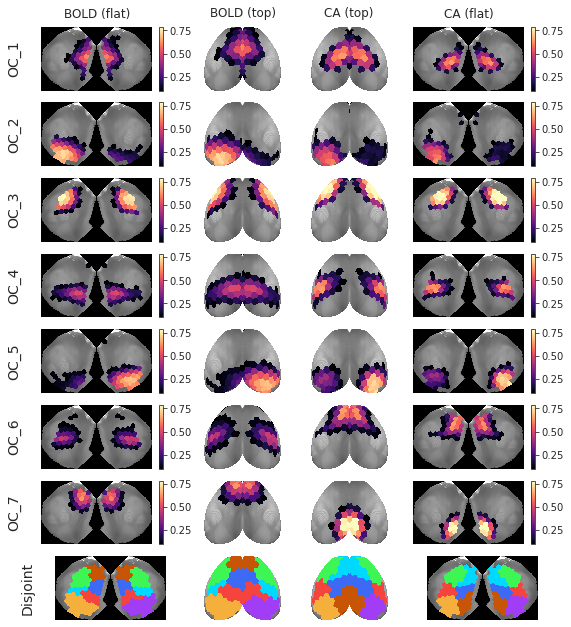

In [8]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

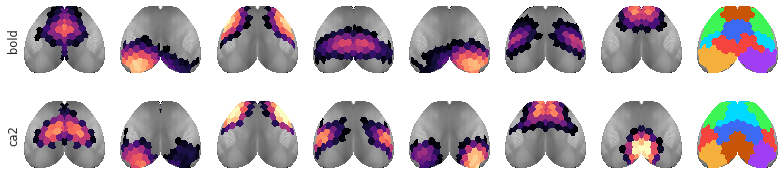

In [12]:
d2p = {
    'bold': gr_bo.trim2d(proj_bo),
    'ca2': gr_ca.trim2d(proj_ca),
}
_ = quick_show(d2p, vmin=0.1, vmax=0.8)

In [13]:
_gr_bo = Group(**props_bo).fit_group()
_ = _gr_bo._merge_vis(0.25)
_gr_ca = Group(**props_ca).fit_group()
_ = _gr_ca._merge_vis(0.25)
d2p = {
    'bold-mg1': _gr_bo.trim2d(_gr_bo.project_vec()),
    **d2p,
    'ca2-mg1': _gr_ca.trim2d(_gr_ca.project_vec())
}

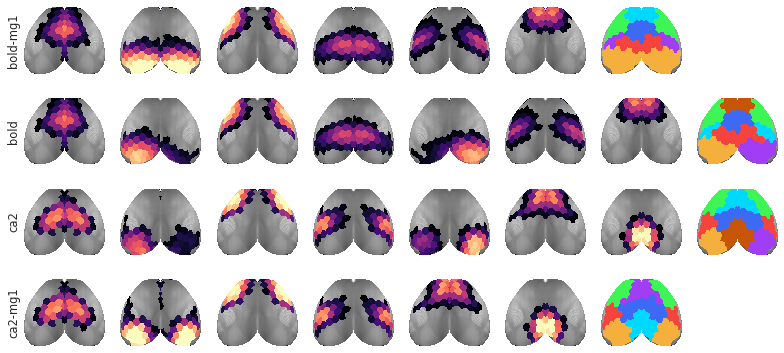

In [14]:
_ = quick_show(d2p, vmin=0.1, vmax=0.8)

In [56]:
pi = bn.nanmean(gr_bo.run_pi, -3)
pi_mg = gr_bo._merge_vis(0.25, apply=False)
pi_mg = bn.nanmean(pi_mg, -3)
pi.shape, pi_mg.shape

((10, 3, 4, 7, 152), (10, 3, 4, 6, 152))

In [45]:
cut = cut_data(
    data=pi.reshape(-1, *pi.shape[-2:]),
    bins=np.linspace(0.0, 1.0, 21),
    oc_only=True,
)[0].reshape(*pi.shape[:3], pi.shape[-2], -1)
cut_grp = bn.nanmean(bn.nanmean(bn.nanmean(
    cut, 2), 1), 0)

[<matplotlib.lines.Line2D object at 0x7f0abc524130>]

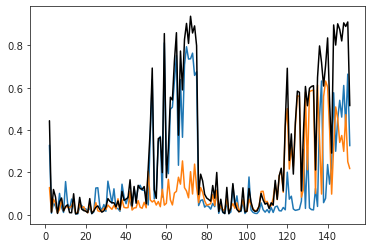

In [57]:
plt.plot(pi[9, 2, 3][[1, 4]].T)
plt.plot(pi_mg[9, 2, 3][1], color='k')

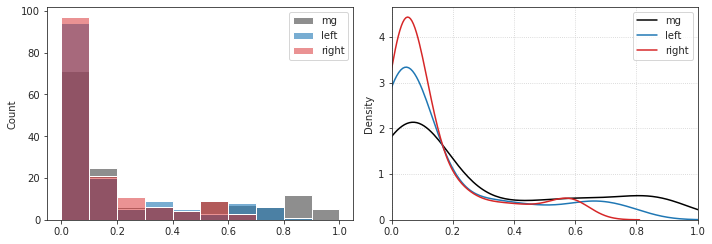

In [75]:
fig, axes = create_figure(1, 2, (10, 3.5))
sns.histplot(pi_mg[9, 2, 3][1], bins=np.linspace(0, 1, 11), color='dimgrey', label='mg', ax=axes[0])
sns.histplot(pi[9, 2, 3][1], bins=np.linspace(0, 1, 11), color='C0', label='left', alpha=0.6, ax=axes[0])
sns.histplot(pi[9, 2, 3][4], bins=np.linspace(0, 1, 11), color='C3', label='right', alpha=0.5, ax=axes[0])
axes[0].legend()

sns.kdeplot(pi_mg[9, 2, 3][1], color='k', label='mg', ax=axes[1])
sns.kdeplot(pi[9, 2, 3][1], color='C0', label='left', ax=axes[1])
sns.kdeplot(pi[9, 2, 3][4], color='C3', label='right', ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].legend()
axes[1].grid()
plt.show()

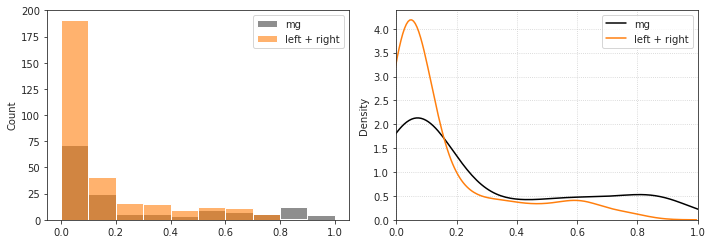

In [141]:
fig, axes = create_figure(1, 2, (10, 3.5))
sns.histplot(pi_mg[9, 2, 3][1], bins=np.linspace(0, 1, 11), color='dimgrey', label='mg', ax=axes[0])
sns.histplot(
    list(pi[9, 2, 3][1]) + list(pi[9, 2, 3][4]),
    bins=np.linspace(0, 1, 11), color='C1', label='left + right', alpha=0.6, ax=axes[0])
axes[0].legend()

sns.kdeplot(pi_mg[9, 2, 3][1], color='k', label='mg', ax=axes[1])
sns.kdeplot(
    list(pi[9, 2, 3][1]) + list(pi[9, 2, 3][4]),
    color='C1', label='left + right', ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].legend()
axes[1].grid()
plt.show()

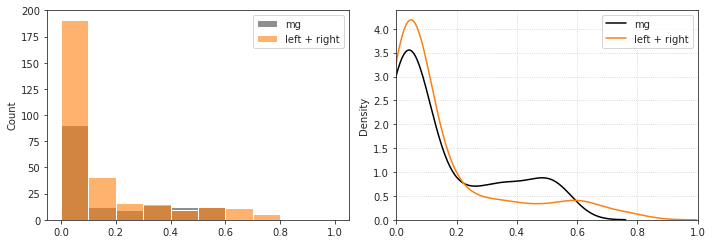

In [143]:
fig, axes = create_figure(1, 2, (10, 3.5))
sns.histplot(pi_mg[9, 2, 3][1] * 0.6, bins=np.linspace(0, 1, 11), color='dimgrey', label='mg', ax=axes[0])
sns.histplot(
    list(pi[9, 2, 3][1]) + list(pi[9, 2, 3][4]),
    bins=np.linspace(0, 1, 11), color='C1', label='left + right', alpha=0.6, ax=axes[0])
axes[0].legend()

sns.kdeplot(pi_mg[9, 2, 3][1] * 0.6, color='k', label='mg', ax=axes[1])
sns.kdeplot(
    list(pi[9, 2, 3][1]) + list(pi[9, 2, 3][4]),
    color='C1', label='left + right', ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].legend()
axes[1].grid()
plt.show()

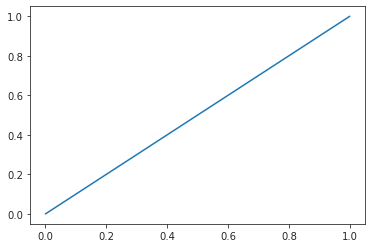

In [136]:
a, b = 2, 1
rv = sp_stats.beta(a, b)

x = np.linspace(0, 1, 100)
y = rv.pdf(x) / a

plt.plot(x, y);

In [89]:
mg = y * (pi[9, 2, 3][1] + pi[9, 2, 3][4])

ValueError: operands could not be broadcast together with shapes (50,) (152,) 

In [90]:
pi[9, 2, 3][1].shape

(152,)

(0.0, 100.0)

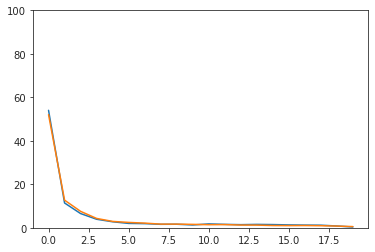

In [46]:
plt.plot(cut_grp[1])
plt.plot(cut_grp[4])
plt.ylim(0, 100)

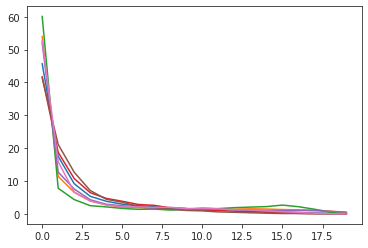

In [47]:
plt.plot(cut_grp.T);

[<matplotlib.lines.Line2D object at 0x7f0abfdf9fd0>]

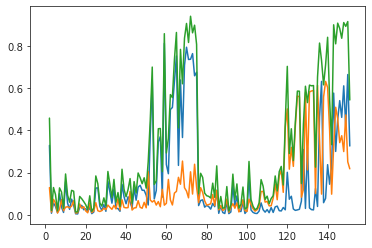

In [48]:
plt.plot(pi[9, 2, 3][[1, 4]].T)
plt.plot(pi[9, 2, 3][1] + pi[9, 2, 3][4])

<matplotlib.legend.Legend object at 0x7f0abe4f8820>

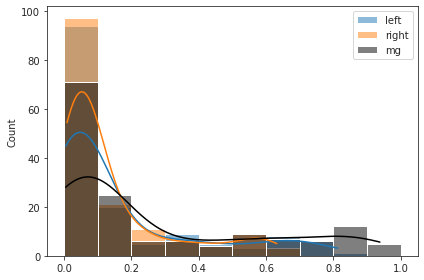

<AxesSubplot:ylabel='Count'>

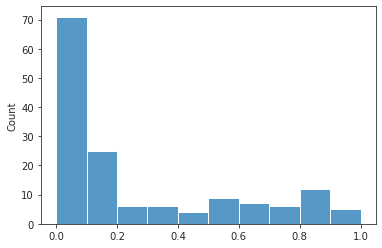

In [9]:
props_bo['num_k'] = num_k + 1
dlist = []
for thres in tqdm(np.linspace(0.2, 0.4, 21)):
    _gr_bo = Group(**props_bo).fit_group()
    _ = _gr_bo._merge_bold(thres, apply=True)
    scores_ovp, scores_disj = _gr_bo.pi_symmetry_score(decimals=10)
    dlist.append({
        'thres': [thres] * len(scores_ovp),
        'label': ['ovp'] * len(scores_ovp),
        'oc_idx': scores_ovp.keys(),
        'values': scores_ovp.values(),
    })
    dlist.append({
        'thres': [thres] * len(scores_ovp),
        'label': ['disj'] * len(scores_ovp),
        'oc_idx': scores_disj.keys(),
        'values': scores_disj.values(),
    })
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/21 [00:00<?, ?it/s]

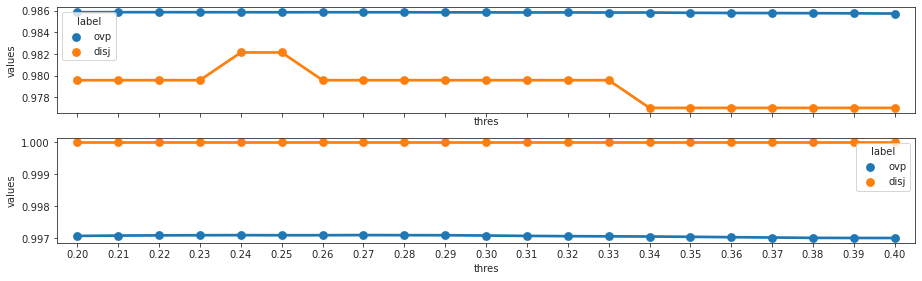

In [10]:
fig, axes = create_figure(2, 1, (13, 4), 'all')

sns.pointplot(
    data=df.loc[df['oc_idx'] == -1],
    x='thres',
    y='values',
    hue='label',
    ax=axes[0],
)
sns.pointplot(
    data=df.loc[df['oc_idx'] == 1],
    x='thres',
    y='values',
    hue='label',
    ax=axes[1],
)
ticklabels = [t.get_text() for t in axes[1].get_xticklabels()]
ticklabels = [f"{float(e):0.2f}" for e in ticklabels]
axes[1].set_xticklabels(ticklabels)
plt.show()

In [11]:
props_bo['num_k'] = 4
_gr_bo = Group(**props_bo).fit_group()
_gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    _gr_bo.run_pi, 3), 2), 1), 0)
d2p['bold=4'] = _gr_bo.trim2d(_gr_bo.project_vec())

In [12]:
thres = 0.25

props_bo['num_k'] = num_k + 1
_gr_bo = Group(**props_bo).fit_group()
_ = _gr_bo._merge_bold(thres)
d2p['bold+1'] = _gr_bo.trim2d(_gr_bo.project_vec())

props_bo['num_k'] = num_k + 2
_gr_bo = Group(**props_bo).fit_group()
_ = _gr_bo._merge_bold(thres)
d2p['bold+2'] = _gr_bo.trim2d(_gr_bo.project_vec())

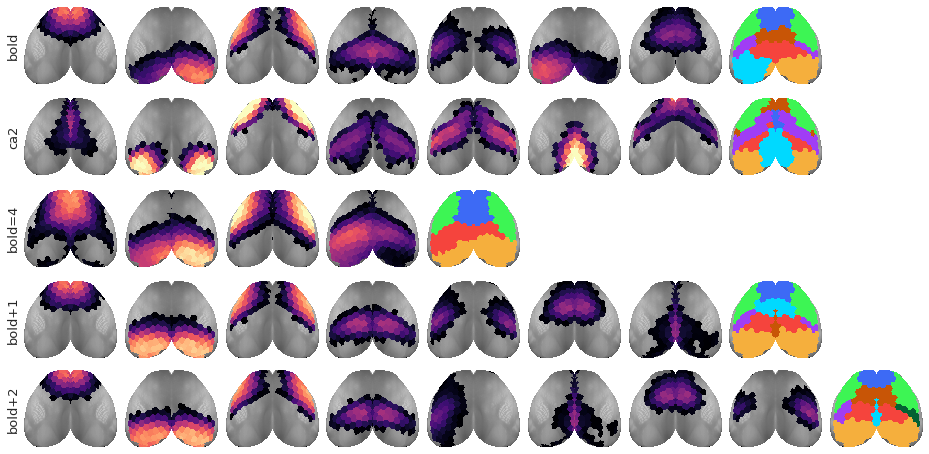

In [13]:
quick_show(d2p, vmin=0.1, vmax=0.8)

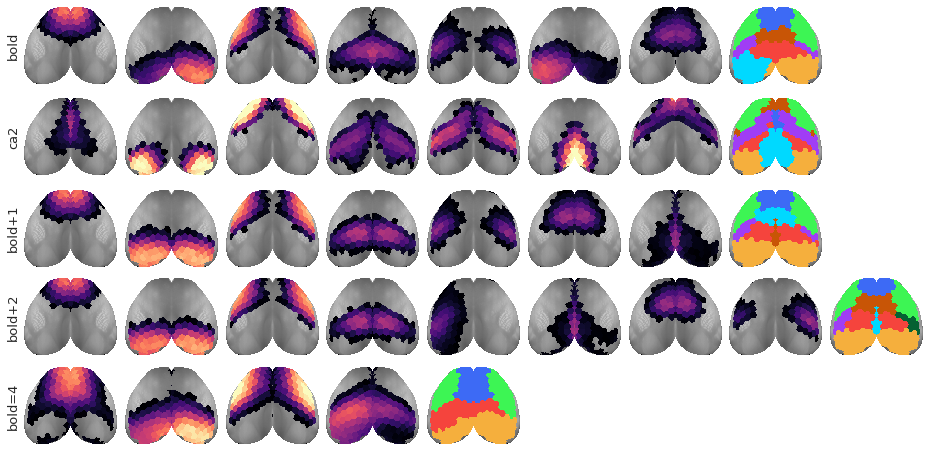

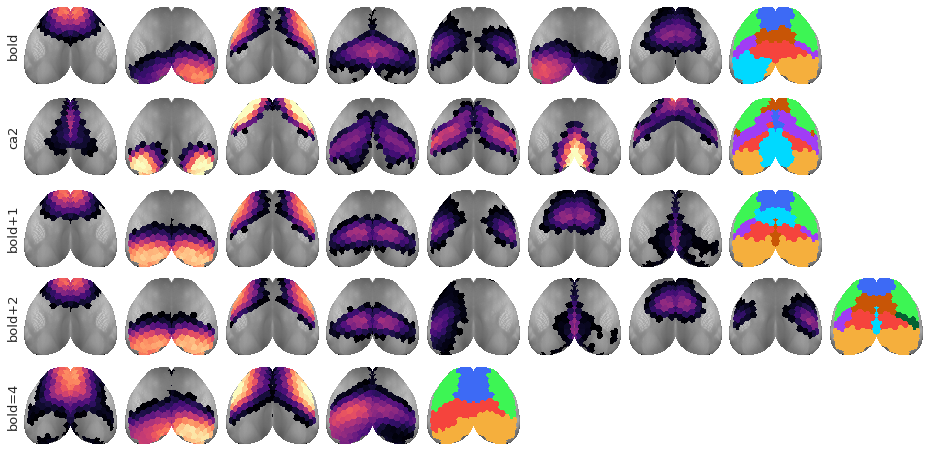

In [26]:
props_bo['num_k'] = num_k + 1
self = Group(**props_bo).fit_group()
# _ = _gr_bo._merge_bold(0.18)
# d2p['bold+1'] = _gr_bo.trim2d(_gr_bo.project_vec())

In [27]:
pi_fuse = self.get_struct_fusion_pi([['VISp']]).squeeze()
visp_l, visp_r = pi_fuse.copy(), pi_fuse.copy()
visp_l[self.r_ids] = 0
visp_r[self.l_ids] = 0

if not (~np.isnan(self.pi)).sum():
    self.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
        self.run_pi, 3), 2), 1), 0)
good = np.isnan(self.pi).sum(0) == 0

idx_r = sp_dist.cdist(
    XA=visp_r.reshape(1, -1)[:, good],
    XB=self.pi[:, good],
    metric='cosine',
).argmin()
idx_l = sp_dist.cdist(
    XA=visp_l.reshape(1, -1)[:, good],
    XB=self.pi[:, good],
    metric='cosine',
).argmin()

if idx_r < idx_l:
    idx_1 = idx_r
    idx_2 = idx_l
elif idx_r > idx_l:
    idx_1 = idx_l
    idx_2 = idx_r
else:
    print(idx_r, idx_l)
    raise RuntimeError

In [37]:
thres = 0

y = self.run_pi.copy()
y[..., idx_1, :][y[..., idx_1, :] < thres] = 0.0
y[..., idx_2, :][y[..., idx_2, :] < thres] = 0.0
y[..., idx_1, :] += y[..., idx_2, :]
y = y[..., np.delete(range(self.num_k), idx_2), :]

In [38]:
y_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(y, 3), 2), 1), 0)

In [39]:
bn.nansum(y_avg, -2)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

<AxesSubplot:ylabel='Count'>

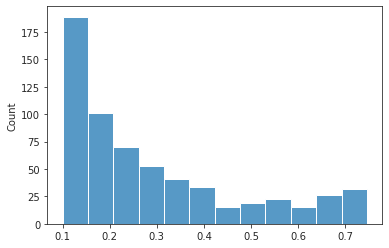

In [27]:
sns.histplot(pi_fix[pi_fix > 0.1])

<AxesSubplot:ylabel='Count'>

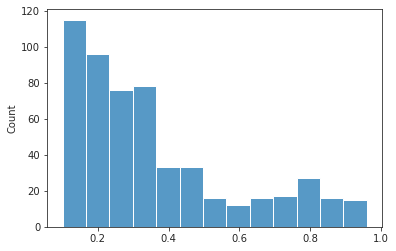

In [28]:
sns.histplot(gr_ca.pi[gr_ca.pi > 0.1])

In [16]:
collections.Counter(left_ids).most_common()

[
    (5, 40327),
    (1, 10653),
    (7, 2442),
    (3, 1322),
    (4, 768),
    (6, 571),
    (0, 194),
    (2, 40)
]

In [17]:
collections.Counter(right_ids).most_common()

[
    (1, 47445),
    (5, 4393),
    (7, 2252),
    (3, 878),
    (0, 438),
    (4, 429),
    (6, 424),
    (2, 58)
]

In [23]:
len(good_run_address), len(bad_run_address)

(13695, 42622)

In [24]:
len(good_run_address) / (len(good_run_address) + len(bad_run_address))

0.24317701582115525

In [26]:
pi_bad = []
pi_good = []
looper = itertools.product(
    range(10), range(3), range(4), range(500))
for ii, jj, kk, ll in tqdm(looper, total=10*3*4*500):
    _pi = gr_bo.run_pi[ii, jj, kk, ll]
    if (ii, jj, kk, ll) in bad_run_address:
        pi_bad.append(np.expand_dims(_pi, 0))
    elif (ii, jj, kk, ll) in good_run_address:
        pi_good.append(np.expand_dims(_pi, 0))
pi_bad = np.concatenate(pi_bad)
pi_good = np.concatenate(pi_good)
pi_bad.shape, pi_good.shape

  0%|          | 0/60000 [00:00<?, ?it/s]

((42622, 8, 224), (13695, 8, 224))

In [27]:
tr_bad = gr_bo.project_vec(bn.nanmean(pi_bad, 0))
tr_good = gr_bo.project_vec(bn.nanmean(pi_good, 0))

tr_bad = gr_bo.trim2d(tr_bad)
tr_good = gr_bo.trim2d(tr_good)

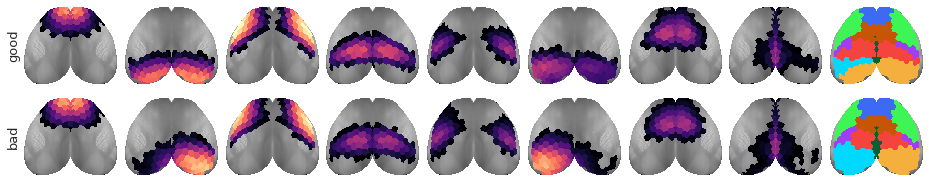

In [29]:
d2p_fix = {'good': tr_good, 'bad': tr_bad}
quick_show(d2p_fix, vmax=0.7)

In [59]:
idx_r, idx_l = 1, 5
if idx_r < idx_l:
    idx_1 = idx_r
    idx_2 = idx_l
elif idx_r > idx_l:
    idx_1 = idx_l
    idx_2 = idx_r
else:
    raise RuntimeError


run_pi_fix = gr_bo.run_pi.copy()
run_pi_fix[..., idx_1, :][run_pi_fix[..., idx_1, :] < 0.1] = 0.0
run_pi_fix[..., idx_2, :][run_pi_fix[..., idx_2, :] < 0.1] = 0.0
run_pi_fix[..., idx_1, :] += run_pi_fix[..., idx_2, :]
run_pi_fix = run_pi_fix[..., np.delete(range(8), idx_2), :]
run_pi_fix /= np.nansum(run_pi_fix, -2, keepdims=True)
run_pi_fix.shape

(10, 3, 4, 500, 7, 224)

In [60]:
pi_fix = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(run_pi_fix, 3), 2), 1), 0)
tr_fix = gr_bo.project_vec(pi_fix)
tr_fix = gr_bo.trim2d(tr_fix)
d2p_fix['fix_normalized'] = tr_fix

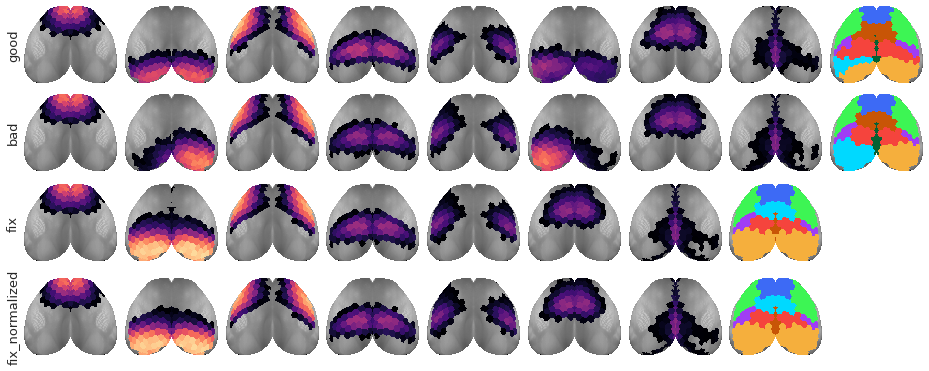

In [69]:
quick_show(d2p_fix, vmax=0.8)

### QUick train a new centroid

In [63]:
accepted_runs, good_global = gr_bo._good_nodes(bn.nanmean(gr_bo.run_pi, 3), 0.97)
len(accepted_runs), len(good_global)

(73, 186)

In [64]:
data = []
looper = itertools.product(
    range(10), range(3), range(4), range(500))
for ii, jj, kk, ll in looper:
    if (ii, jj, kk) not in accepted_runs:
        continue
    _pi = gr_bo.run_pi[ii, jj, kk, ll]
    good = np.isnan(_pi).sum(0) == 0
    if not good.sum():
        continue
    data.append(_pi)
data = np.concatenate(data)
data.shape

(287880, 224)

In [65]:
np.isnan(data[:, good_global]).sum()

0

In [66]:
centroids = np.zeros((8, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, good_global],
    n_clusters=8,
    match_metric=gr_bo.sv_props['match_metric'],
    random_state=mice.cfg.random_state,
)
centroids[:, good_global] = _centroids
centroids.shape

(8, 224)

In [67]:
centroids /= np.nansum(centroids, -2, keepdims=True)
tr_c = gr_bo.project_vec(centroids)
tr_c = gr_bo.trim2d(tr_c)

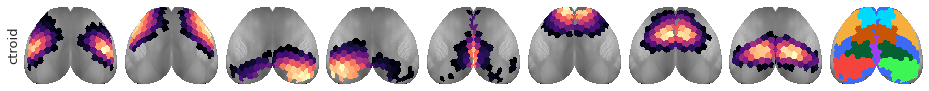

In [68]:
quick_show({'ctroid': tr_c})

In [51]:
shape = np.array(gr_bo.run_pi.shape)
shape[-2] -= 1

pi_fixed = np_nans(shape)

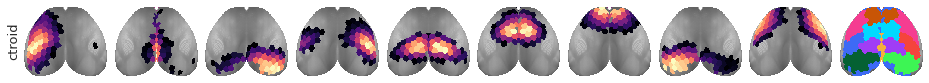

### --- end train centroid

In [94]:
pi_fixed = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(run_pi_fixed, 3), 2), 1), 0)
tr = gr_bo.project_vec(pi_fixed)
tr = gr_bo.trim2d(tr)

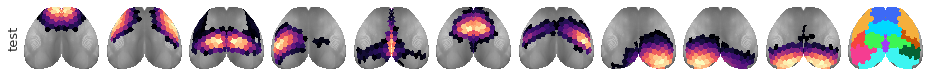

In [95]:
quick_show({'test': tr})

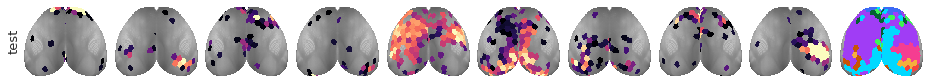

In [51]:
sp_dist.cdist(visp_l.reshape(1, -1)[:, good], _pi[:, good], 'cosine').argmin()

6

1

In [8]:
# idx_1, idx_2 = 5, 10
pi = gr_bo.pi.copy()

# pi[idx_1][pi[idx_1] < 0.1] = 0
# pi[idx_2][pi[idx_2] < 0.1] = 0
# pi[idx_1] += pi[idx_2]
# pi = pi[np.delete(range(num_k), idx_2)]
# pi = pi / np.nansum(pi, -2, keepdims=True)
# pi = pi[[0, 5, 2, 3, 6, 9, 4, 7, 8, 1]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [9]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

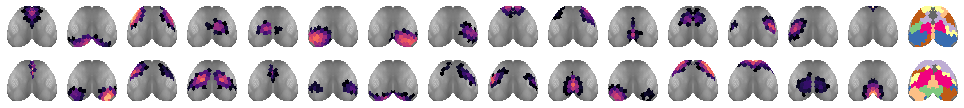

In [10]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.6, figsize=(13.5, 1.8))

In [11]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.22035009250466656, 0.5133969315039946)

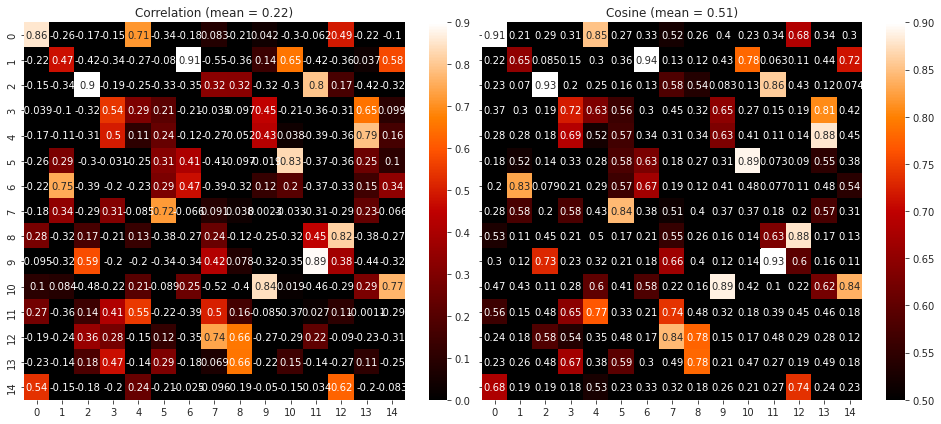

In [12]:
fig, axes = create_figure(1, 2, (13.5, 6.), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.5, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [13]:
gmap = find_best_match(sim_cos, global_order=False)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[0, 6, 2, 13, 3, 10, 1, 5, 12, 11, 9, 4, 7, 8, 14]

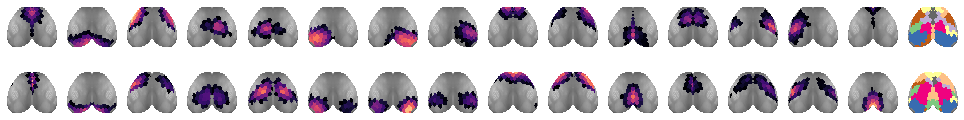

In [19]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.08,
    vmax=0.6,
    figsize=(13.5, 2.3),
)

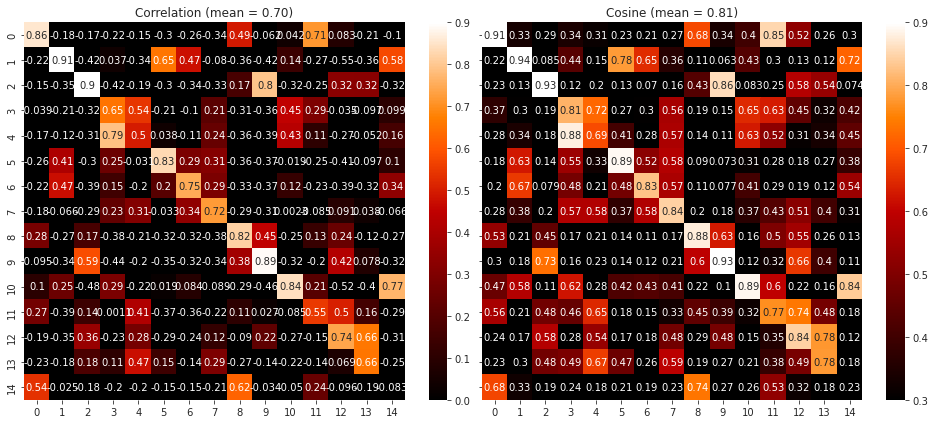

In [20]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

fig, axes = create_figure(1, 2, (13.5, 6), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.3, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [21]:
sim_cos.diagonal()

array([0.90965838, 0.94476281, 0.93362208, 0.80897372, 0.68891875,
       0.89098225, 0.82882552, 0.84398334, 0.87836167, 0.92708892,
       0.88899753, 0.76723698, 0.84449265, 0.77998194, 0.22639209])